In [1]:
# ============================================
# Cell 0: Imports, config, and scoring dict
# ============================================

import os
import re
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    matthews_corrcoef,
    roc_auc_score,
)

import matplotlib.pyplot as plt

# ---- Paths (assuming notebook is in PROJECT folder) ----
POS_FASTA = "Positive_Final.fasta"    # positives = RBPs
NEG_FASTA = "Negative_Final.fasta"    # negatives = non-RBPs
PSSM_DIR  = "pssm_out"           # folder containing <sanitized_id>.pssm

# ---- Amino acid definitions ----
AA_ORDER = list("ACDEFGHIKLMNPQRSTVWY")
AA_INDEX = {aa: i for i, aa in enumerate(AA_ORDER)}

RANDOM_STATE = 42

# ---- Scoring metrics for cross-validation ----
scoring = {
    "accuracy": "accuracy",
    "precision": "precision",
    "recall": "recall",
    "f1": "f1",
    "roc_auc": "roc_auc",
}


In [2]:
# =========================
# Cell 1: Helper: sanitize_id
# =========================

def sanitize_id(raw_id: str) -> str:
    """
    Make a safe filename from a FASTA header ID.
    Must match the logic used in split.py.
    - Keep letters, digits, underscore, dash, dot.
    - Replace everything else with '_'.
    - Limit length to 80 chars (safety).
    """
    safe = re.sub(r"[^A-Za-z0-9_.-]", "_", raw_id)
    return safe[:80]


In [3]:
# =========================
# Cell 2: FASTA → DataFrame
# =========================

def read_fasta(path):
    """
    Minimal FASTA reader.
    Returns dict: {sequence_id: sequence_string}
    sequence_id = first token after '>' (full header kept only for that token).
    """
    seqs = {}
    header = None
    parts = []
    with open(path, "r") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            if line.startswith(">"):
                if header is not None:
                    seqs[header] = "".join(parts).replace(" ", "").upper()
                header = line[1:].split()[0]   # ID is first token after '>'
                parts = []
            else:
                parts.append(line)
    if header is not None:
        seqs[header] = "".join(parts).replace(" ", "").upper()
    return seqs


# Load datasets
pos_seqs = read_fasta(POS_FASTA)
neg_seqs = read_fasta(NEG_FASTA)

print(f"Loaded {len(pos_seqs)} positive (RBP) sequences")
print(f"Loaded {len(neg_seqs)} negative (non-RBP) sequences")

def build_labeled_df(pos_dict, neg_dict):
    rows = []
    for sid, seq in pos_dict.items():
        rows.append({"id": sid, "sequence": seq, "label": 1})
    for sid, seq in neg_dict.items():
        rows.append({"id": sid, "sequence": seq, "label": 0})
    return pd.DataFrame(rows)

df = build_labeled_df(pos_seqs, neg_seqs)

print(df.head())
print("\nLabel counts:")
print(df["label"].value_counts())
print("\nSequence length stats:")
print(df["sequence"].str.len().describe())


Loaded 3741 positive (RBP) sequences
Loaded 3712 negative (non-RBP) sequences
                          id  \
0  sp|A0A0A7HFE1|CAS10_STRTR   
1  sp|A0A0A7HIX6|CSM6A_STRTR   
2   sp|A0A0B4KGY6|NOVA_DROME   
3   sp|A0A0D1DWZ5|RRM4_MYCMD   
4  sp|A0A0F6B5X4|TACT3_SALT1   

                                            sequence  label  
0  MKKEKIDLFYGALLHDIGKVIQRATGERKKHALVGADWFDEIADNQ...      1  
1  MKILISAVGTTDPISNNHDAALLHIARNYRPDKIVLVYSQEMMVKQ...      1  
2  MESIMKVAMDKAAEQLIQQFGFDYLQQQLQLQHQNQHNSSPQQPQH...      1  
3  MSDSIYAPHNKHKLEAARAADAAADDAATVSALVEPTDSTAQASHA...      1  
4  MMFTDWHEAAIGKTHNRMNFDCGDADLNQFLQRHARQNHEKGTTKT...      1  

Label counts:
label
1    3741
0    3712
Name: count, dtype: int64

Sequence length stats:
count    7453.000000
mean      464.597478
std       441.237939
min        50.000000
25%       197.000000
50%       352.000000
75%       579.000000
max      5628.000000
Name: sequence, dtype: float64


In [4]:
# =========================
# Cell 3: AAC features
# =========================

def compute_aac(seq, aa_order=AA_ORDER):
    """
    Amino Acid Composition (AAC):
    p_i = l_i / L, where l_i is count of AA i and L is sequence length.
    Returns len(aa_order)-dim numpy array.
    """
    counts = np.zeros(len(aa_order), dtype=float)
    L = 0
    for aa in seq:
        if aa in AA_INDEX:
            counts[AA_INDEX[aa]] += 1
            L += 1
    if L > 0:
        counts /= L
    return counts


# Quick sanity check
test_aac = compute_aac(df["sequence"].iloc[0])
print("AAC length:", len(test_aac))
print("AAC sum:", test_aac.sum())


AAC length: 20
AAC sum: 1.0


In [5]:
# ===================================
# Cell 4: Physico-chemical properties
# ===================================

# TODO: replace 0.0 with real values from the PRBP paper or other trusted sources.
# 6 properties × 20 amino acids
PHYSICOCHEMICAL_PROPERTIES = {
    "pka_amino":    {aa: 0.0 for aa in AA_ORDER},
    "pka_carboxyl": {aa: 0.0 for aa in AA_ORDER},
    "mass":         {aa: 0.0 for aa in AA_ORDER},
    "eiip":         {aa: 0.0 for aa in AA_ORDER},
    "lone_pairs":   {aa: 0.0 for aa in AA_ORDER},
    "wiener_index": {aa: 0.0 for aa in AA_ORDER},
}

def normalize_property_vector(values_dict):
    """
    Normalize a property vector to [0, 1] across the 20 amino acids.
    """
    vals = np.array([values_dict[aa] for aa in AA_ORDER], dtype=float)
    vmin = vals.min()
    vmax = vals.max()
    if vmax == vmin:
        return np.zeros_like(vals)
    return (vals - vmin) / (vmax - vmin)


In [6]:
# ===========================================
# Cell 5: PSSM loading and EIPP computation
# ===========================================

def load_pssm_for_sequence(seq_id, pssm_dir=PSSM_DIR):
    """
    Load ASCII PSSM file for a given sequence id.
    We sanitize the ID to match the filenames produced by split.py.
    Expected path: <pssm_dir>/<sanitized_id>.pssm
    Returns numpy array of shape (L, 20).
    """
    safe_id = sanitize_id(seq_id)
    path = os.path.join(pssm_dir, f"{safe_id}.pssm")
    if not os.path.exists(path):
        raise FileNotFoundError(
            f"PSSM not found for {seq_id} (sanitized: {safe_id}): {path}"
        )

    rows = []
    with open(path, "r") as f:
        for line in f:
            parts = line.strip().split()
            # Example: columns: idx, AA, 20 scores, ...
            if len(parts) >= 22 and parts[0].isdigit():
                scores = [float(x) for x in parts[2:22]]
                rows.append(scores)
    if not rows:
        raise ValueError(f"No PSSM rows parsed for {seq_id} (sanitized: {safe_id}) at {path}")
    return np.array(rows, dtype=float)


def normalize_pssm(pssm_raw):
    """
    Sigmoid normalization: f(x) = 1 / (1 + exp(-x)).
    """
    return 1.0 / (1.0 + np.exp(-pssm_raw))


def compute_eipp_features(seq_id, seq, pssm_dir=PSSM_DIR):
    """
    Compute 120-dim EIPP feature for a sequence:
      6 normalized properties × 20 amino acid types.

    Handles small mismatches between sequence length and PSSM length by
    truncating both to the minimum length.
    """
    pssm_raw = load_pssm_for_sequence(seq_id, pssm_dir=pssm_dir)
    
    L_pssm = pssm_raw.shape[0]
    L_seq  = len(seq)

    if L_pssm != L_seq:
        # Truncate to the minimum length so indices still line up
        minL = min(L_pssm, L_seq)
        pssm_raw = pssm_raw[:minL, :]
        seq = seq[:minL]

    # Normalize PSSM
    pssm_norm = normalize_pssm(pssm_raw)  # shape (L, 20)

    # Normalize each property vector across 20 amino acids
    normalized_props = {
        name: normalize_property_vector(values)
        for name, values in PHYSICOCHEMICAL_PROPERTIES.items()
    }

    eipp_vec = []

    for prop_name, da in normalized_props.items():      # 6 properties
        for aa_k in AA_ORDER:                           # 20 amino acids
            positions = [i for i, aa in enumerate(seq) if aa == aa_k]
            if not positions:
                eipp_vec.append(0.0)
                continue
            sub_pssm = pssm_norm[positions, :]          # (#pos, 20)
            f_k = sub_pssm.mean(axis=0)                 # mean PSSM over those positions
            contrib = np.sum(np.sqrt(da) * f_k)         # Eq.(5)-style contribution
            eipp_vec.append(contrib)

    return np.array(eipp_vec, dtype=float)


# Optional quick test on first sequence (will work once PSSMs exist for that ID)
# sid0 = df["id"].iloc[0]
# seq0 = df["sequence"].iloc[0]
# eipp0 = compute_eipp_features(sid0, seq0)
# print("EIPP length:", len(eipp0))


In [7]:
# =======================================
# Cell 6: Feature extraction (EIPP + AAC)
# =======================================

def extract_features_eipp_aac(df, pssm_dir=PSSM_DIR):
    """
    Build feature matrix using:
      - AAC (20)
      - EIPP (120)
      - sequence length (1)
    Total: 141 features.
    """
    X_list = []
    y_list = []
    ids = []

    for _, row in df.iterrows():
        seq_id = row["id"]
        seq    = row["sequence"]
        label  = row["label"]

        aac    = compute_aac(seq)                                 # 20
        eipp   = compute_eipp_features(seq_id, seq, pssm_dir=pssm_dir)  # 120
        length = np.array([len(seq)], dtype=float)                # 1

        feats = np.concatenate([aac, eipp, length])
        X_list.append(feats)
        y_list.append(label)
        ids.append(seq_id)

    X = np.vstack(X_list)
    y = np.array(y_list, dtype=int)
    ids = np.array(ids)
    return X, y, ids


# Build feature matrix
X_eipp, y_eipp, ids_eipp = extract_features_eipp_aac(df)
print("Feature matrix shape (EIPP + AAC + length):", X_eipp.shape)


Feature matrix shape (EIPP + AAC + length): (7453, 141)


In [8]:
# =======================================
# Cell 7: Train/test + RF (EIPP + AAC)
# =======================================

X_train_e, X_test_e, y_train_e, y_test_e = train_test_split(
    X_eipp,
    y_eipp,
    test_size=0.2,
    stratify=y_eipp,
    random_state=RANDOM_STATE,
)

rf_eipp = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    class_weight="balanced",
    n_jobs=-1,
    random_state=RANDOM_STATE,
)

rf_eipp.fit(X_train_e, y_train_e)

y_pred_e = rf_eipp.predict(X_test_e)
y_proba_e = rf_eipp.predict_proba(X_test_e)[:, 1]

print("=== RF (EIPP + AAC) - test set ===")
print(f"Accuracy:  {accuracy_score(y_test_e, y_pred_e):.4f}")
print(f"Precision: {precision_score(y_test_e, y_pred_e):.4f}")
print(f"Recall:    {recall_score(y_test_e, y_pred_e):.4f}")
print(f"F1-score:  {f1_score(y_test_e, y_pred_e):.4f}")
print(f"MCC:       {matthews_corrcoef(y_test_e, y_pred_e):.4f}")
print(f"AUC:       {roc_auc_score(y_test_e, y_proba_e):.4f}")


=== RF (EIPP + AAC) - test set ===
Accuracy:  0.7344
Precision: 0.7262
Recall:    0.7553
F1-score:  0.7405
MCC:       0.4691
AUC:       0.8198


In [9]:
# =======================================
# Cell 8: 5-fold CV (EIPP + AAC + RF)
# =======================================

rf_eipp_cv = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    class_weight="balanced",
    n_jobs=-1,
    random_state=RANDOM_STATE,
)

cv_eipp = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

cv_results_eipp = cross_validate(
    rf_eipp_cv,
    X_eipp,
    y_eipp,
    cv=cv_eipp,
    scoring=scoring,
    n_jobs=-1,
)

print("=== 5-fold CV (EIPP + AAC + RF) ===")
for metric, values in cv_results_eipp.items():
    if metric.startswith("test_"):
        name = metric.replace("test_", "")
        print(f"{name:10s}: mean={values.mean():.4f}, std={values.std():.4f}")


=== 5-fold CV (EIPP + AAC + RF) ===
accuracy  : mean=0.7451, std=0.0048
precision : mean=0.7373, std=0.0081
recall    : mean=0.7648, std=0.0128
f1        : mean=0.7507, std=0.0052
roc_auc   : mean=0.8266, std=0.0076


Top 20 most important features (RF, EIPP + AAC):
     feature  importance
8      AAC_K    0.083627
14     AAC_R    0.067045
18     AAC_W    0.065720
9      AAC_L    0.051835
140  SEQ_LEN    0.050257
3      AAC_E    0.048112
4      AAC_F    0.047368
16     AAC_T    0.047037
1      AAC_C    0.047018
10     AAC_M    0.043461
0      AAC_A    0.042291
15     AAC_S    0.041700
5      AAC_G    0.041640
13     AAC_Q    0.041329
2      AAC_D    0.041264
12     AAC_P    0.041006
11     AAC_N    0.040860
19     AAC_Y    0.040306
7      AAC_I    0.040049
17     AAC_V    0.039613


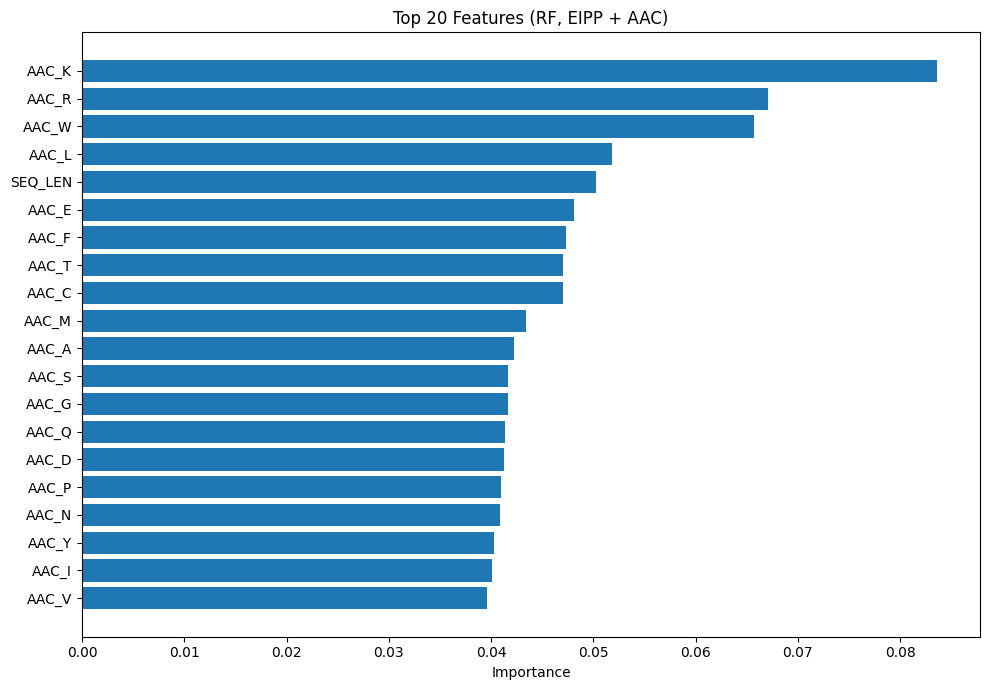

In [10]:
# =======================================
# Cell 9: Feature importances (optional)
# =======================================

aac_names = [f"AAC_{aa}" for aa in AA_ORDER]
eipp_names = [f"EIPP_p{p}_aa{aa}" for p in range(1, 7) for aa in AA_ORDER]  # 6×20
feat_names = aac_names + eipp_names + ["SEQ_LEN"]

importances = rf_eipp.feature_importances_
imp_df_e = pd.DataFrame({
    "feature": feat_names,
    "importance": importances
}).sort_values("importance", ascending=False)

print("Top 20 most important features (RF, EIPP + AAC):")
print(imp_df_e.head(20))

# Optional plot
plt.figure(figsize=(10, 7))
top20 = imp_df_e.head(20)[::-1]
plt.barh(top20["feature"], top20["importance"])
plt.title("Top 20 Features (RF, EIPP + AAC)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


In [11]:
# =======================================
# Cell 10: Predict 5 random proteins
# =======================================

all_probs_e = rf_eipp.predict_proba(X_eipp)[:, 1]
all_preds_e = rf_eipp.predict(X_eipp)

results_e = df.copy()
results_e["pred_label_rf_eipp"] = all_preds_e
results_e["pred_proba_RBP_rf_eipp"] = all_probs_e

sample5_e = results_e.sample(n=5, random_state=RANDOM_STATE)

print("=== RF (EIPP + AAC) predictions for 5 random proteins ===\n")
for _, row in sample5_e.iterrows():
    print(f"ID:            {row['id']}")
    print(f"True label:    {row['label']}   (1 = RBP, 0 = non-RBP)")
    print(f"Predicted:     {row['pred_label_rf_eipp']}")
    print(f"P(RBP | seq):  {row['pred_proba_RBP_rf_eipp']:.4f}")
    seq = row["sequence"]
    print(f"Seq (first 60 aa): {seq[:60]}{'...' if len(seq) > 60 else ''}")
    print("-" * 60)


=== RF (EIPP + AAC) predictions for 5 random proteins ===

ID:            sp|O48398|GP42_BPSP1
True label:    0   (1 = RBP, 0 = non-RBP)
Predicted:     0
P(RBP | seq):  0.1580
Seq (first 60 aa): MRKFVTTLTASPRNKKVGNHRLEISPFVSLRRYYYFNTAICIENPVTREFAIDDSYGSLS...
------------------------------------------------------------
ID:            sp|Q6AQA5|RLMKL_DESPS
True label:    1   (1 = RBP, 0 = non-RBP)
Predicted:     1
P(RBP | seq):  0.7660
Seq (first 60 aa): MCDKKDVSPQKDQYTFLANCALGLEELIEAEIKGFSGVEVELGKGTVQWQGSLETGYRAC...
------------------------------------------------------------
ID:            sp|P64578|HIGB_ECOLI
True label:    1   (1 = RBP, 0 = non-RBP)
Predicted:     1
P(RBP | seq):  0.8080
Seq (first 60 aa): MHLITQKALKDAAEKYPQHKTELVALGNTIAKGYFKKPESLKAVFPSLDNFKYLDKHYVF...
------------------------------------------------------------
ID:            sp|Q976I5|RL40_SULTO
True label:    0   (1 = RBP, 0 = non-RBP)
Predicted:     0
P(RBP | seq):  0.2340
Seq (first 60 aa): MPLTDPVKLQIVQQRIFLKKV